https://numbersandshapes.net/post/fitting_sir_to_data_in_python/

In [1]:
import datetime

import yaml
import os

import numpy as np
import pandas as pd

In [2]:
ENV_FILE='../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

#Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE= os.path.join(ROOT_DIR, params['directories']['processed'], params['files']['all_data'])

#Lecture du fihcier de données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=['Last Update'])
               .assign(day=lambda _df:_df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df['day'] <= datetime.date(2020,3,12)]
              )

In [3]:
epidemie_df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,source,day
0,Anhui,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,31.8257,117.2264,01-22-2020.csv,2020-01-22
1,Beijing,Mainland China,2020-01-22 17:00:00,14.0,NaN,NaN,40.1824,116.4142,01-22-2020.csv,2020-01-22
2,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,NaN,NaN,30.0572,107.8740,01-22-2020.csv,2020-01-22
3,Fujian,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,26.0789,117.9874,01-22-2020.csv,2020-01-22
4,Gansu,Mainland China,2020-01-22 17:00:00,NaN,NaN,NaN,36.0611,103.8343,01-22-2020.csv,2020-01-22


In [4]:
france_df=(epidemie_df[epidemie_df['Country/Region']=='France']
           .groupby(['Country/Region', 'day'])
           .agg({'Confirmed': 'sum', 'Deaths':'sum','Recovered':'sum'})
           .reset_index()
          )
france_df.tail()


,Country/Region,day,Confirmed,Deaths,Recovered
23,France,2020-03-07,949.0,11.0,12.0
24,France,2020-03-08,1126.0,19.0,12.0
25,France,2020-03-09,1209.0,19.0,12.0
26,France,2020-03-10,1784.0,33.0,12.0
27,France,2020-03-11,2287.0,48.0,12.0


In [5]:
france_df['Confirmed'].diff()

0       NaN
1       1.0
2       0.0
3       0.0
4       1.0
5       1.0
6       0.0
7       0.0
8       1.0
9       5.0
10      0.0
11      1.0
12      2.0
13      4.0
14     20.0
15     19.0
16     43.0
17     30.0
18     61.0
19     13.0
20     81.0
21     92.0
22    276.0
23    296.0
24    177.0
25     83.0
26    575.0
27    503.0
Name: Confirmed, dtype: float64

In [6]:
def get_country(self, country):
    return (epidemie_df[epidemie_df['Country/Region']==country]
           .groupby(['Country/Region', 'day'])
           .agg({'Confirmed': 'sum', 'Deaths':'sum','Recovered':'sum'})
           .reset_index()
           )
#Monkey Patch pd.Dataframe
pd.DataFrame.get_country = get_country           

In [7]:
get_country(epidemie_df, 'South Korea').head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,South Korea,2020-01-22,1.0,0.0,0.0
1,South Korea,2020-01-23,1.0,0.0,0.0
2,South Korea,2020-01-24,2.0,0.0,0.0
3,South Korea,2020-01-25,2.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0


In [8]:
epidemie_df.get_country('South Korea').head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,South Korea,2020-01-22,1.0,0.0,0.0
1,South Korea,2020-01-23,1.0,0.0,0.0
2,South Korea,2020-01-24,2.0,0.0,0.0
3,South Korea,2020-01-25,2.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0


In [9]:
korea_df=epidemie_df.get_country('South Korea')
korea_df.head()
italy_df=epidemie_df.get_country('Italy')
italy_df.head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,Italy,2020-01-31,2.0,0.0,0.0
1,Italy,2020-02-07,3.0,0.0,0.0
2,Italy,2020-02-21,20.0,1.0,0.0
3,Italy,2020-02-22,62.0,2.0,1.0
4,Italy,2020-02-23,155.0,3.0,2.0


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
korea_df['infected'] = korea_df['Confirmed'].diff()
italy_df['infected'] = italy_df['Confirmed'].diff()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


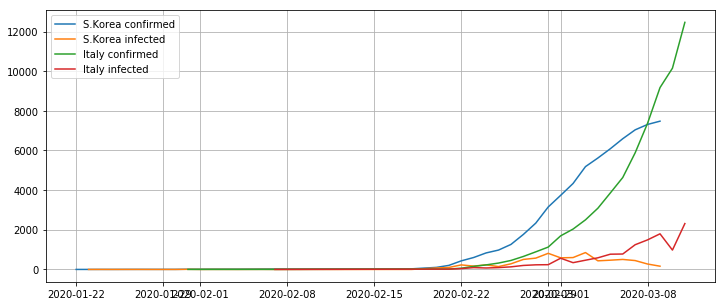

In [12]:
fig = plt.figure(figsize=(12,5))
plt.plot(korea_df.day, korea_df['Confirmed'], label='S.Korea confirmed')
plt.plot(korea_df.day, korea_df['infected'], label='S.Korea infected' )
plt.plot(italy_df.day, italy_df['Confirmed'], label='Italy confirmed')
plt.plot(italy_df.day, italy_df['infected'], label='Italy infected')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
beta,gamma = [0.01,0.1]

def SIR(t,y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

In [14]:
korea_df.loc[2:].head()

,Country/Region,day,Confirmed,Deaths,Recovered,infected
2,South Korea,2020-01-24,2.0,0.0,0.0,1.0
3,South Korea,2020-01-25,2.0,0.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0,1.0
5,South Korea,2020-01-27,4.0,0.0,0.0,1.0
6,South Korea,2020-01-28,4.0,0.0,0.0,0.0


In [15]:
from scipy.integrate import solve_ivp
beta,gamma = [0.01,0.1]
solution_korea = solve_ivp(SIR,[0,40],[51_470_000,1,0],t_eval=np.arange(0,40,1))

In [16]:
def plot_epidemia(solution, infected):
    fig = plt.figure(figsize=(12,5))
    plt.plot(solution.t,solution.y[0])
    plt.plot(solution.t,solution.y[1])
    plt.plot(solution.t,solution.y[2])
    plt.plot(infected.reset_index(drop=True).index,infected,"k*:")
    plt.grid("True")
    plt.legend(["Susceptible","Infected","Removed","Original Data"])
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


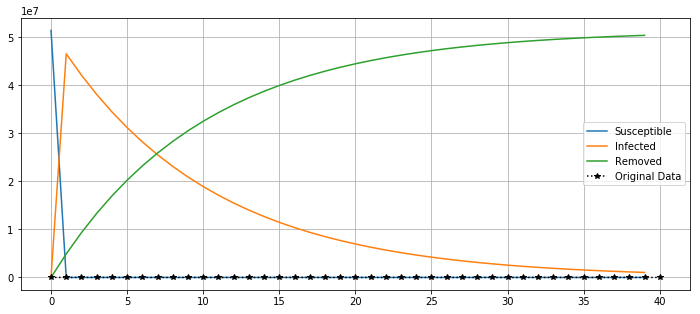

In [17]:
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

In [18]:
korea_df['infected'].max()

851.0

In [19]:
korea_df['Recovered'].diff().max()

94.0

In [20]:
(korea_df['Recovered'].diff().loc[korea_df['infected'] !=0]/korea_df['infected'].loc[korea_df['infected'] !=0]).mean()

0.17870945831971552

In [21]:
beta,gamma = [0.00000001,0.15]
solution_korea = solve_ivp(SIR,[0,40],[51_470_000,1,0],t_eval=np.arange(0,40,1))

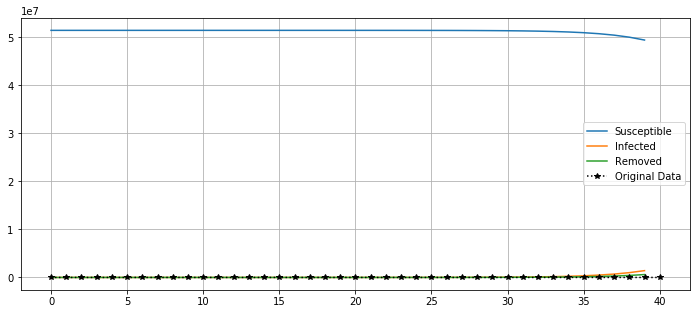

In [22]:
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

In [23]:
def sumsq_error(parameters):
    beta, gamma = parameters
    def SIR(t,y):
        S=y[0]
        I=y[1]
        R=y[2]
        return([-beta*S*I, beta*S*I-gamma*I, gamma*I])
    
    solution = solve_ivp(SIR,[0,nb_steps-1],[total_population,1,0],t_eval=np.arange(0,nb_steps,1))
        
    return(sum((solution.y[1]-infected_population)**2))


In [24]:
total_population = 51_470_000
infected_population = korea_df.loc[2:]['infected']
nb_steps = len(infected_population)

In [25]:
%%time
from scipy.optimize import minimize

msol = minimize(sumsq_error,[0.001,0.1],method='Nelder-Mead')
msol.x

KeyboardInterrupt: 

In [26]:
beta_optimal = 5.67e-3
gamma_optimal = 24.7

In [27]:
beta = beta_optimal
gamma = gamma_optimal
solution_korea_optimal = solve_ivp(SIR,[0,40],[51_470_000,1,0],t_eval=np.arange(0,40,1))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


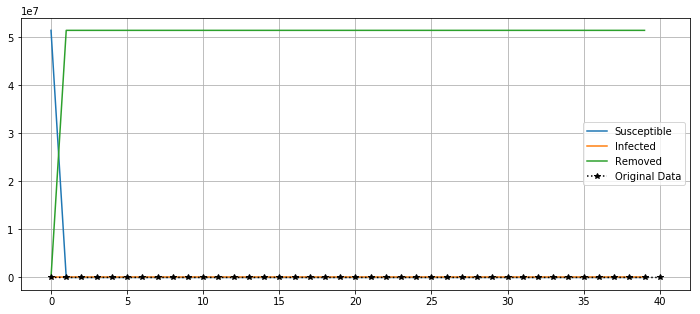

In [28]:
plot_epidemia(solution_korea_optimal, korea_df.loc[2:]['infected'])

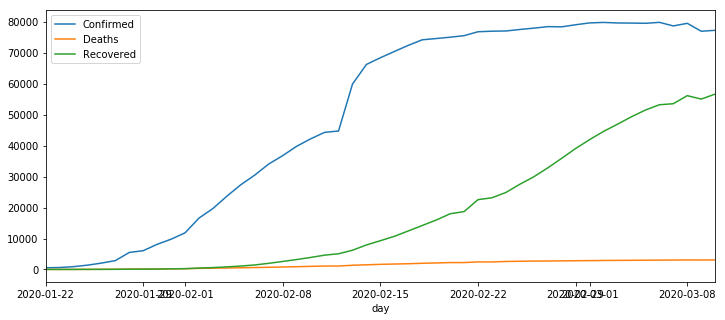

In [30]:
china_df= epidemie_df.get_country('Mainland China')[:49]
china_df.set_index('day').plot.line(figsize=(12,5))

In [31]:
beta, gamma = [0.001, 0.1]
china_df['infected'] = china_df['Confirmed'].diff()
nb_steps = china_df.shape[0]
solution_china = solve_ivp(SIR, [0,40], [1_350_470_000, 1 ,0], t_eval=np.arange(0,41,1))

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.plot(solution_china.t,solution_china.y[1])
plt.plot(china_df.loc[2:]['infected'].reset_index(drop=True).index,china_df.loc[2:]['infected'],"k*:")
plt.title('China')
plt.grid("True")
plt.legend(["Infected","Original Data"])
plt.show()